# 梯度提升树的提前停止

在学习机器学习理论与方法时，我们极少提及迭代的提前停止问题。在机器学习中，依赖于迭代进行工作的算法并不算多，同时课程中的数据量往往也比较小，因此难以预见需要提前停止迭代以节省计算资源或时间的情况。但对于工业界使用最广泛的GBDT而言，提前停止是需要考虑的关键问题。

对于任意需要迭代的算法，迭代的背后往往是损失函数的最优化问题。例如在逻辑回归中，我们在进行梯度下降的迭代时，是希望找到交叉熵损失函数的最小值：而在梯度提升树中，我们在一轮轮建立弱评估器过程中，也是希望找到对应损失函数的最小值。理想状态下，无论使用什么算法，只要我们能够找到损失函数上真正的最小值，那模型就达到“收敛”状态，迭代就应该被停止。

然而遗憾的是，我们和算法都不知道损失函数真正的最小值是多少，而算法更不会在达到收敛状态时就自然停止。在机器学习训练流程中，我们性往是通过给出一个极限资源来控制算法的停止，比如，我们通过超参数设置允许某个算法迭代的最大次数，或者允许建立的弱评估器的个数。因此无论算法是否在很短时间内就锁定了足够接近理论最小值的次小值、或者算法早已陷入了过拟合状态、甚至学习率太低号致算法无法收敛，大多数算法都会持续（且无效地）迭代下去，直到我们给与的极限资源全部被耗尽。对于复杂度较高、数据量较大的Boosting.集成算法来说，无效的迭代常常发生，因此作为众多Boosting.算法的根基算法，梯度提升树自带了提前停止的相关超参数。另外，逻辑回归看起来会自然停止，是因为逻辑回归内置提前停止机制。

我们根据以下原则来帮助梯度提升树实现提前停止：

* 当GBDT已经达到了足够好的效果（非常接近收敛状态）,持续迭代下去不会有助于提升算法表现
* GBDT还没有达到足够好的效果（没有接近收敛），但迭代过程中呈现出越迭代算法表现越槽糕的情况
* 虽然GBDT还没有达到足够好的效果，但是训练时间太长/速度太慢，我们需要重新调整训练

第三种情况可以通过参数verbose打印结果来观察，如果GBDT的训川练时间超过半个小时，建树平均时长超出1分钟，我们就可以打断训练考虑重调参数。前两种情况则比较复杂，我们首先必须理解什么叫做“足够好的效果“。在GBDT迭代过程中，只要损失函数的值持续减小、或验证集上的分数持续上升，我们就可以认为GBDT的效果还有提升空间。在实际训练过程中，刚开始训练时，测试集和训练集上的损失一殷都很高（有时，训练集上的损失甚至比测试集上的损失还高，这说明模型严重欠训练），但随着训练次数的增多，两种损失都会开始快速下降，一般训练集下降得更快，测试集下降得缓慢。直到某一次迭代时，无论我们如何训练，测试集上的损失都不再下降，甚至开始升高，此时我们就需要让迭代停下。

如下图所示，下图中横坐标为迭代次数，纵坐标为损失函数的值。当测试集上的损失不再下降、持续保持平稳时，满足条件1，继续训练会浪费训川练资源，迭代下去模型也会停滞不前，因此需要停止（左图）。当测试集上的损失开始升高时，往往训练集上的损失还是在稳步下降，继续迭代下去就会造成训练集损失比测试集损失小很多的情况，也就是过拟合（右侧），此时满足条件2，也需要提前停止。在过拟合之前及时停止，能够防止模型被迭代到过拟合状况下。

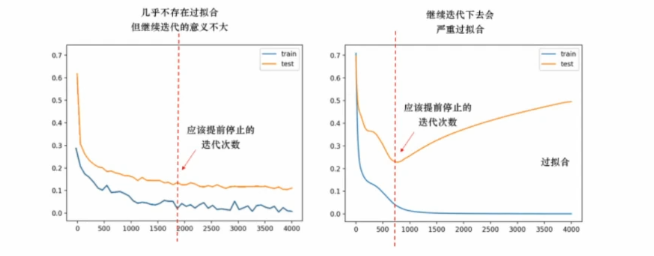

在实际数据训练时，我们往往不能动用真正的测试集进行提前停止的验证，因此我们需要从训练集中划分出一小部分数据，专用于验证是否应该提前停止。那我们如何找到这个验证集损失不再下降、准确率不再上升的某一时间点呢？此时，我们可以规定一个阈值，例如，当连续n_1ter_no_change次送代中，验证集上损失函数的减小值都低于阀值to1,或者验证集的分数提升值都低于阀值to1的时候，我们就令迭代停止，此时，即便我们规定的n estimators或者ma×iter中的数量还没有被用完，我们也可以认为算法已经非常接近收敛而将训练停下。这种机制就是提前停止机制Early Stopping。这种机制中，需要设置阈值to1,用于不新检验损失函数下降量的验证集，以及损失函数连续停止下降的迭代轮数n_iter_no_change。在GBDT当中，这个流程刚好由以下三个参数控制：

* validation_fraction:从训练集中提取出、用于提前停止的验证数据占比，值域为0,1。
  
* n_iter_no_change:当验证集上的损失函数值连续n_iter_.no_change次没有下降或下降量不达阈值时，则触发提前停止。平时则设置为None,表示不进行提前停止。
  
* to1：损失函数下降的减值，默认值为1e-4，也可调整为其他浮点数来观察提前停止的情况。

需要注意的是，当提前停止条件被触发后，梯度提升树会停止训练，即停止建树。因此，当提前停止功能被设置打开时，我们使用属性n_estimators调出的结果很可能不足我们设置的n_estimators,属性estimators_中的树数量也可能变得更少：

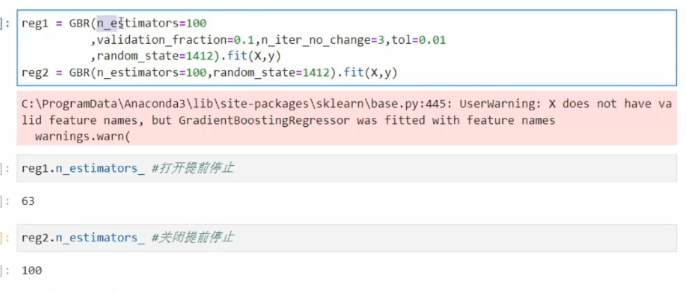

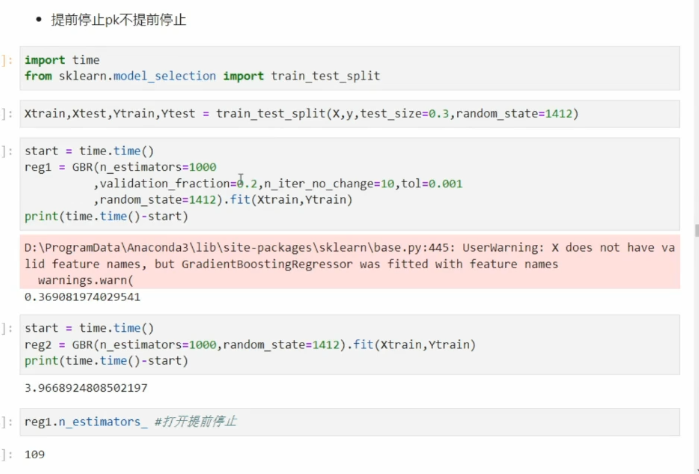

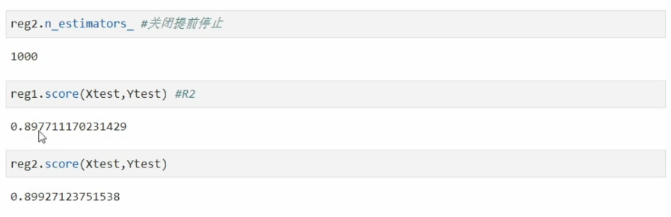

什么时候使用提前停止呢？一般有以下几种场景：
* 当数据量非常大，肉眼可见训练速度会非常缓慢的时候，开启提前停止以节约运算时间
* n_estimators参数范围极广、可能涉及到需要500~1000棵树时，开启提前停止来寻找可能的更小n_estimators取值
* 当数据量非常小，模型很可能快速陷入过拟合状况时，开启提前停止来防止过拟合

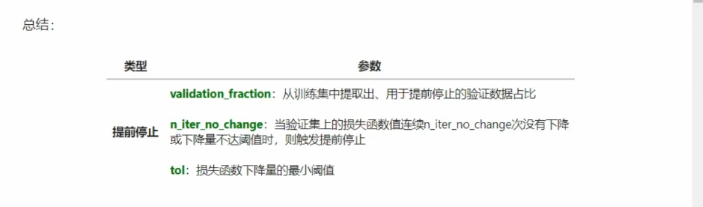